# W-ICA

In [1]:
from data_slicing.slicing import get_data
from data_slicing.metadata import metadata
import mne
import numpy as np
import importlib
from matplotlib import pyplot
import pywt

In [2]:
patient_code = "p10"
patient_metadata = metadata[patient_code]
records = patient_metadata["records"]
record = records[0]
normal_record, seizure_record, info = get_data(record)

Extracting EDF parameters from D:\workspace2\eeg-epilepsy\data\EpilepticEEGDataset\p10_Record1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5401499  =      0.000 ... 10802.998 secs...
=== record_time === 2023-04-04 05:36:39
s_index, s_index_end:  3599500 3822000
=== raw_data.shape ===  (19, 5401500)
=== normal_record.shape ===  (19, 5179000)
=== seizure_record.shape ===  (19, 222500)


In [3]:
start = 0
length = 12800
used_record = normal_record
used_data = used_record[:, start:start+length]
new_info = mne.create_info(info["ch_names"], ch_types=["eeg"] * len(info["ch_names"]), sfreq=500)
raw = mne.io.RawArray(used_record[:, start:start+length], new_info)

Creating RawArray with float64 data, n_channels=19, n_times=12800
    Range : 0 ... 12799 =      0.000 ...    25.598 secs
Ready.


In [4]:
from online_system import emd_ica_artifact_removal
importlib.reload(emd_ica_artifact_removal)
ica_components, ica, ica_raw = emd_ica_artifact_removal.ICA_decompose(used_data, info["ch_names"])

Creating RawArray with float64 data, n_channels=19, n_times=12800
    Range : 0 ... 12799 =      0.000 ...    25.598 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


Fitting ICA took 0.7s.


In [5]:
from wica import wt
importlib.reload(wt)
ica_components_data = ica_components.get_data()
wt_coff = wt.stationary_wt(np.array(ica_components_data[0]), level=6)

## Test Soft Thresholding

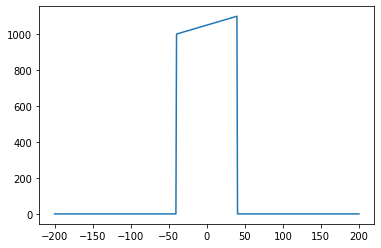

In [6]:
from wica import wt
importlib.reload(wt)
def fx(x):
    return 0
values = []
for x in range(-100, 100):
    values.append(x)
for x in range(1000, 1100):
    values.append(x)
for x in range(-100, 100):
    values.append(x)
threshed_data = wt.soft_thresholding(values)
pyplot.plot(np.linspace(-200, 200, 500), threshed_data, '-');

## Apply Soft Thresholding to WT Coefficients

In [7]:
wt_coff

[{'a': array([-0.70529288, -0.70304396, -0.70086735, ..., -0.71250242,
         -0.71002023, -0.70761761]),
  'd': array([-1.29283427, -1.22784058, -1.15578434, ..., -1.43413568,
         -1.3971632 , -1.34967834])},
 {'a': array([-0.53026983, -0.52968779, -0.52903156, ..., -0.53090396,
         -0.53092395, -0.53069857]),
  'd': array([-2.86759594, -2.61696526, -2.31921409, ..., -3.21050146,
         -3.17654069, -3.05837095])},
 {'a': array([-0.30447457, -0.28163157, -0.25791071, ..., -0.36647304,
         -0.34717136, -0.32642236]),
  'd': array([-2.89124191, -2.16830647, -1.42520677, ..., -3.93019736,
         -3.89080394, -3.50574635])},
 {'a': array([-0.22020472, -0.17276216, -0.13514098, ..., -0.32549952,
         -0.29859309, -0.26323218]),
  'd': array([-0.45987489,  0.64939597,  1.00619952, ..., -5.18052348,
         -4.18947229, -2.29345595])},
 {'a': array([ 0.05855939, -0.12918875, -0.47014476, ..., -0.19734205,
         -0.09166565,  0.0381841 ]),
  'd': array([ 1.1648202

In [8]:
threshed_wt_coff = []
for level_coff in wt_coff:
    threshed_wt_coff.append({
        'a': wt.soft_thresholding(level_coff['a']),
        'd': wt.soft_thresholding(level_coff['d'])
    })
threshed_wt_coff

[{'a': array([0., 0., 0., ..., 0., 0., 0.]),
  'd': array([-1.29283427,  0.        ,  0.        , ..., -1.43413568,
         -1.3971632 , -1.34967834])},
 {'a': array([0., 0., 0., ..., 0., 0., 0.]),
  'd': array([-2.86759594, -2.61696526, -2.31921409, ..., -3.21050146,
         -3.17654069, -3.05837095])},
 {'a': array([0., 0., 0., ..., 0., 0., 0.]),
  'd': array([-2.89124191, -2.16830647, -1.42520677, ..., -3.93019736,
         -3.89080394, -3.50574635])},
 {'a': array([0., 0., 0., ..., 0., 0., 0.]),
  'd': array([-0.45987489,  0.64939597,  1.00619952, ..., -5.18052348,
         -4.18947229, -2.29345595])},
 {'a': array([0., 0., 0., ..., 0., 0., 0.]),
  'd': array([ 1.16482022,  1.01902443,  0.66229317, ..., -5.69563167,
         -1.54830891,  0.96069606])},
 {'a': array([0., 0., 0., ..., 0., 0., 0.]),
  'd': array([-0.19359098, -0.41069197,  0.01298462, ..., -3.00060831,
          0.99092841,  1.04579654])}]

## Inverse WT

In [9]:
artifact_component = pywt.iswtn(threshed_wt_coff, 'coif5')

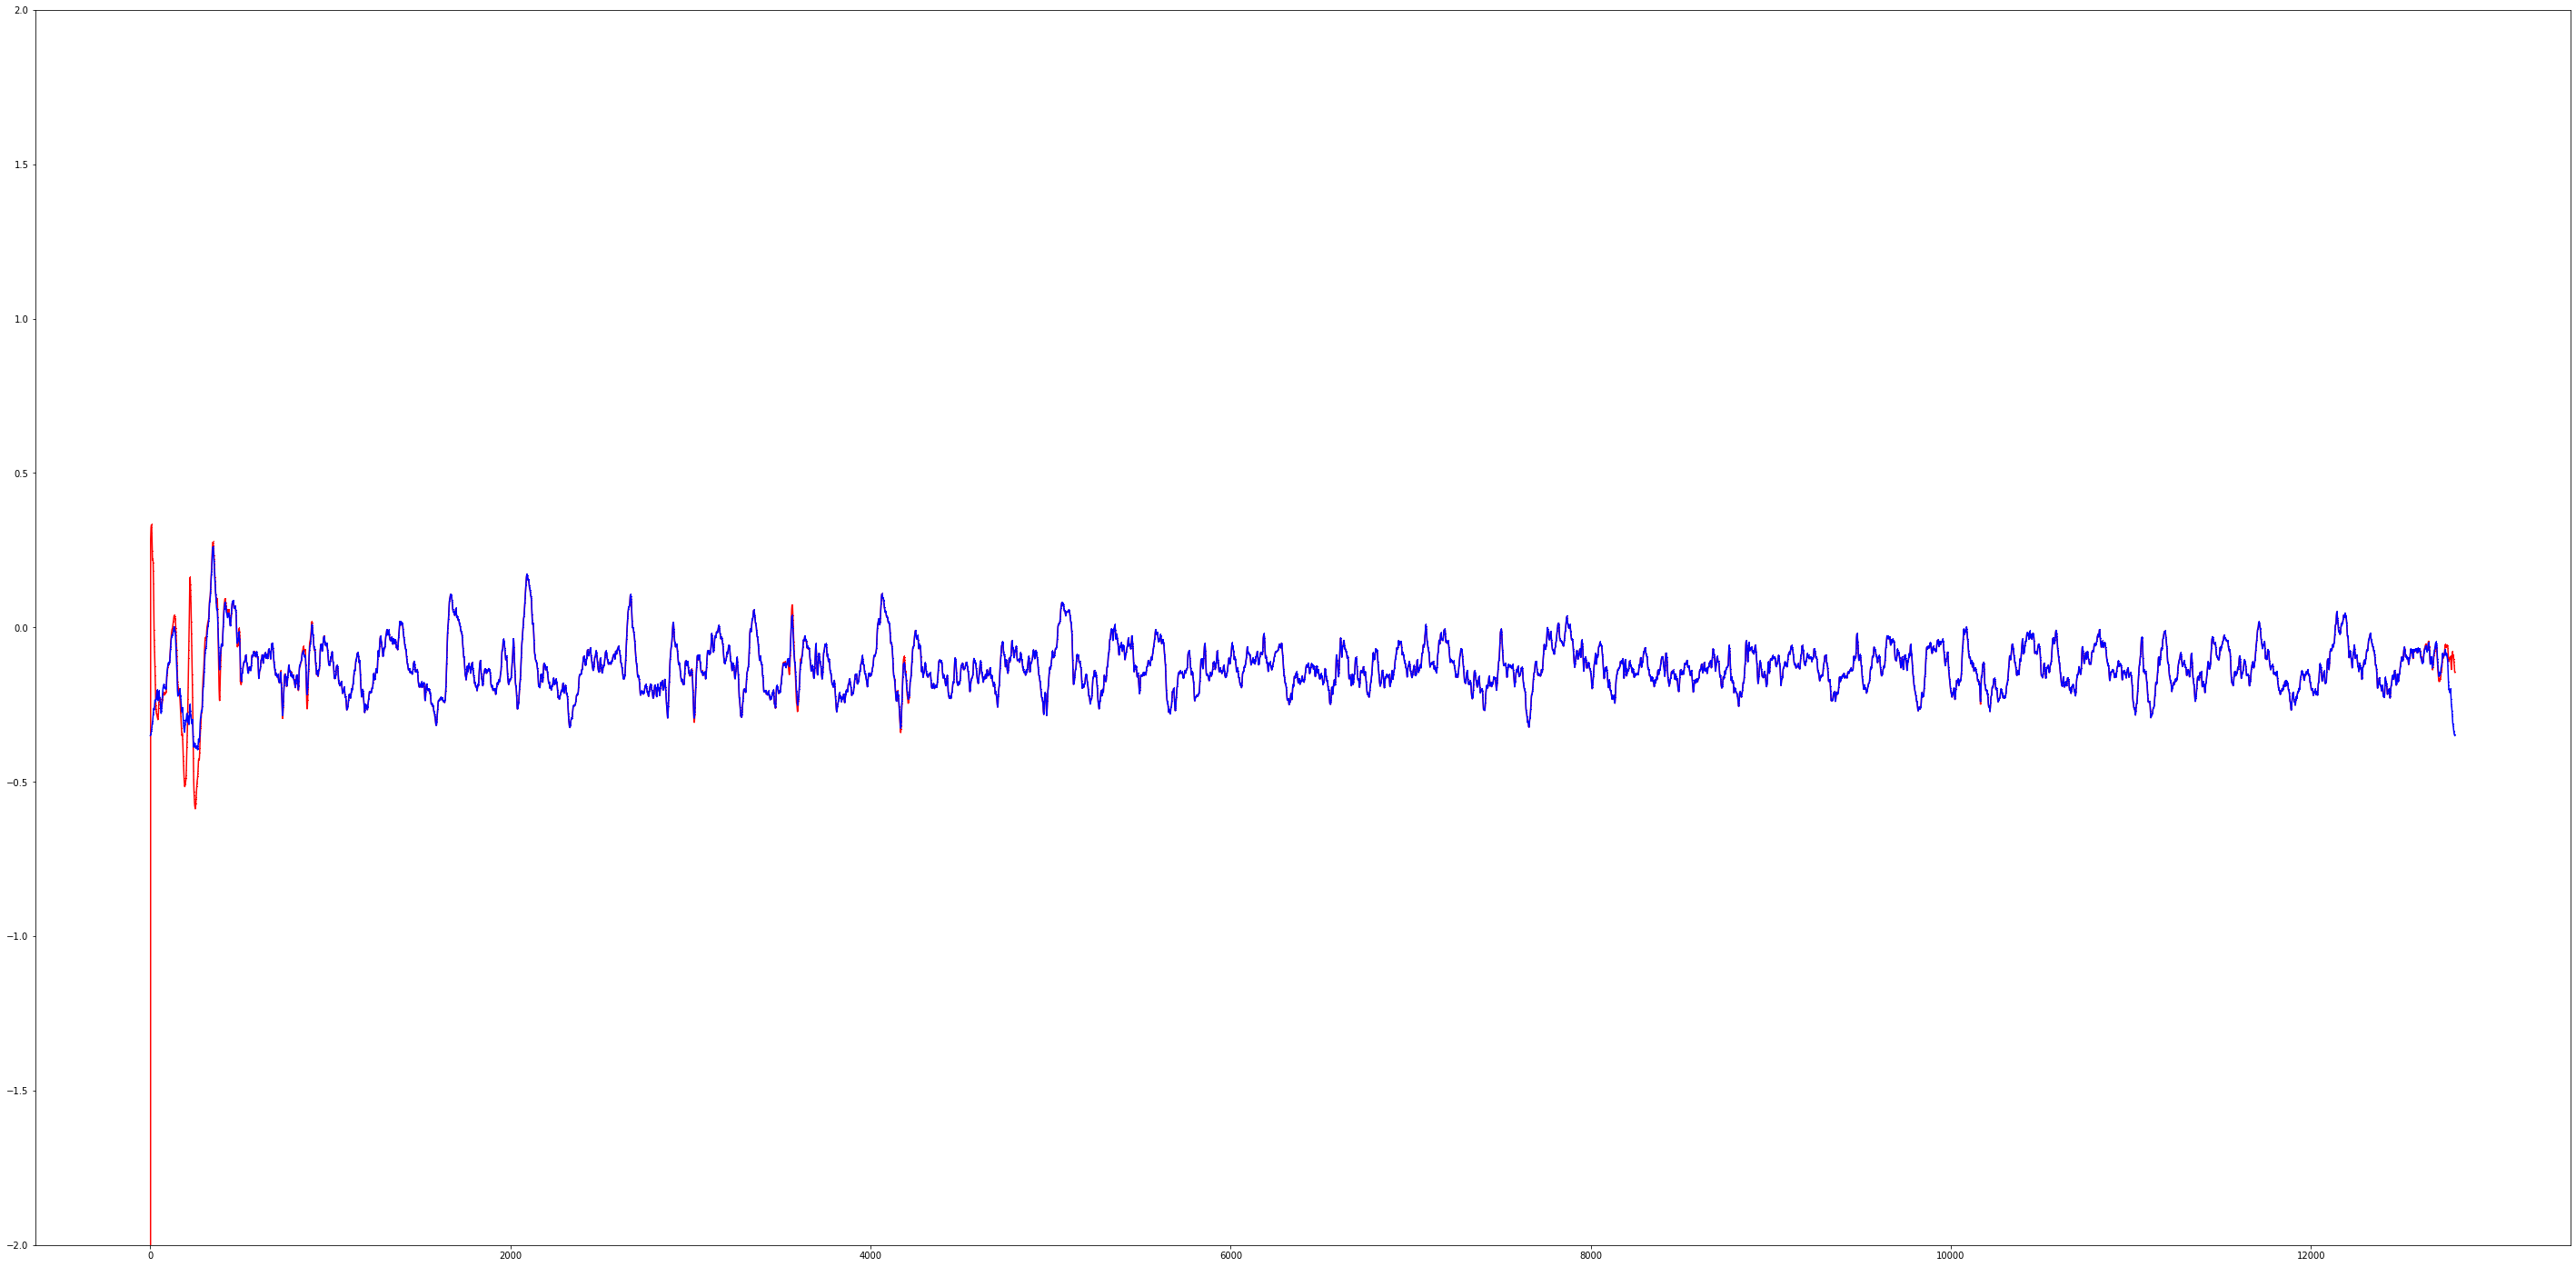

In [10]:
figure1 = pyplot.figure(0, (50, 25))
pyplot.ylim(-2, 2)
component_without_artifact = ica_components_data[0] - np.array(artifact_component)
pyplot.plot(np.linspace(0, len(ica_components_data[0]), len(ica_components_data[0])), ica_components_data[0], ',-', color ='r')
pyplot.plot(np.linspace(0, len(component_without_artifact), len(component_without_artifact)), component_without_artifact, ',-', color ='b')

# Testing

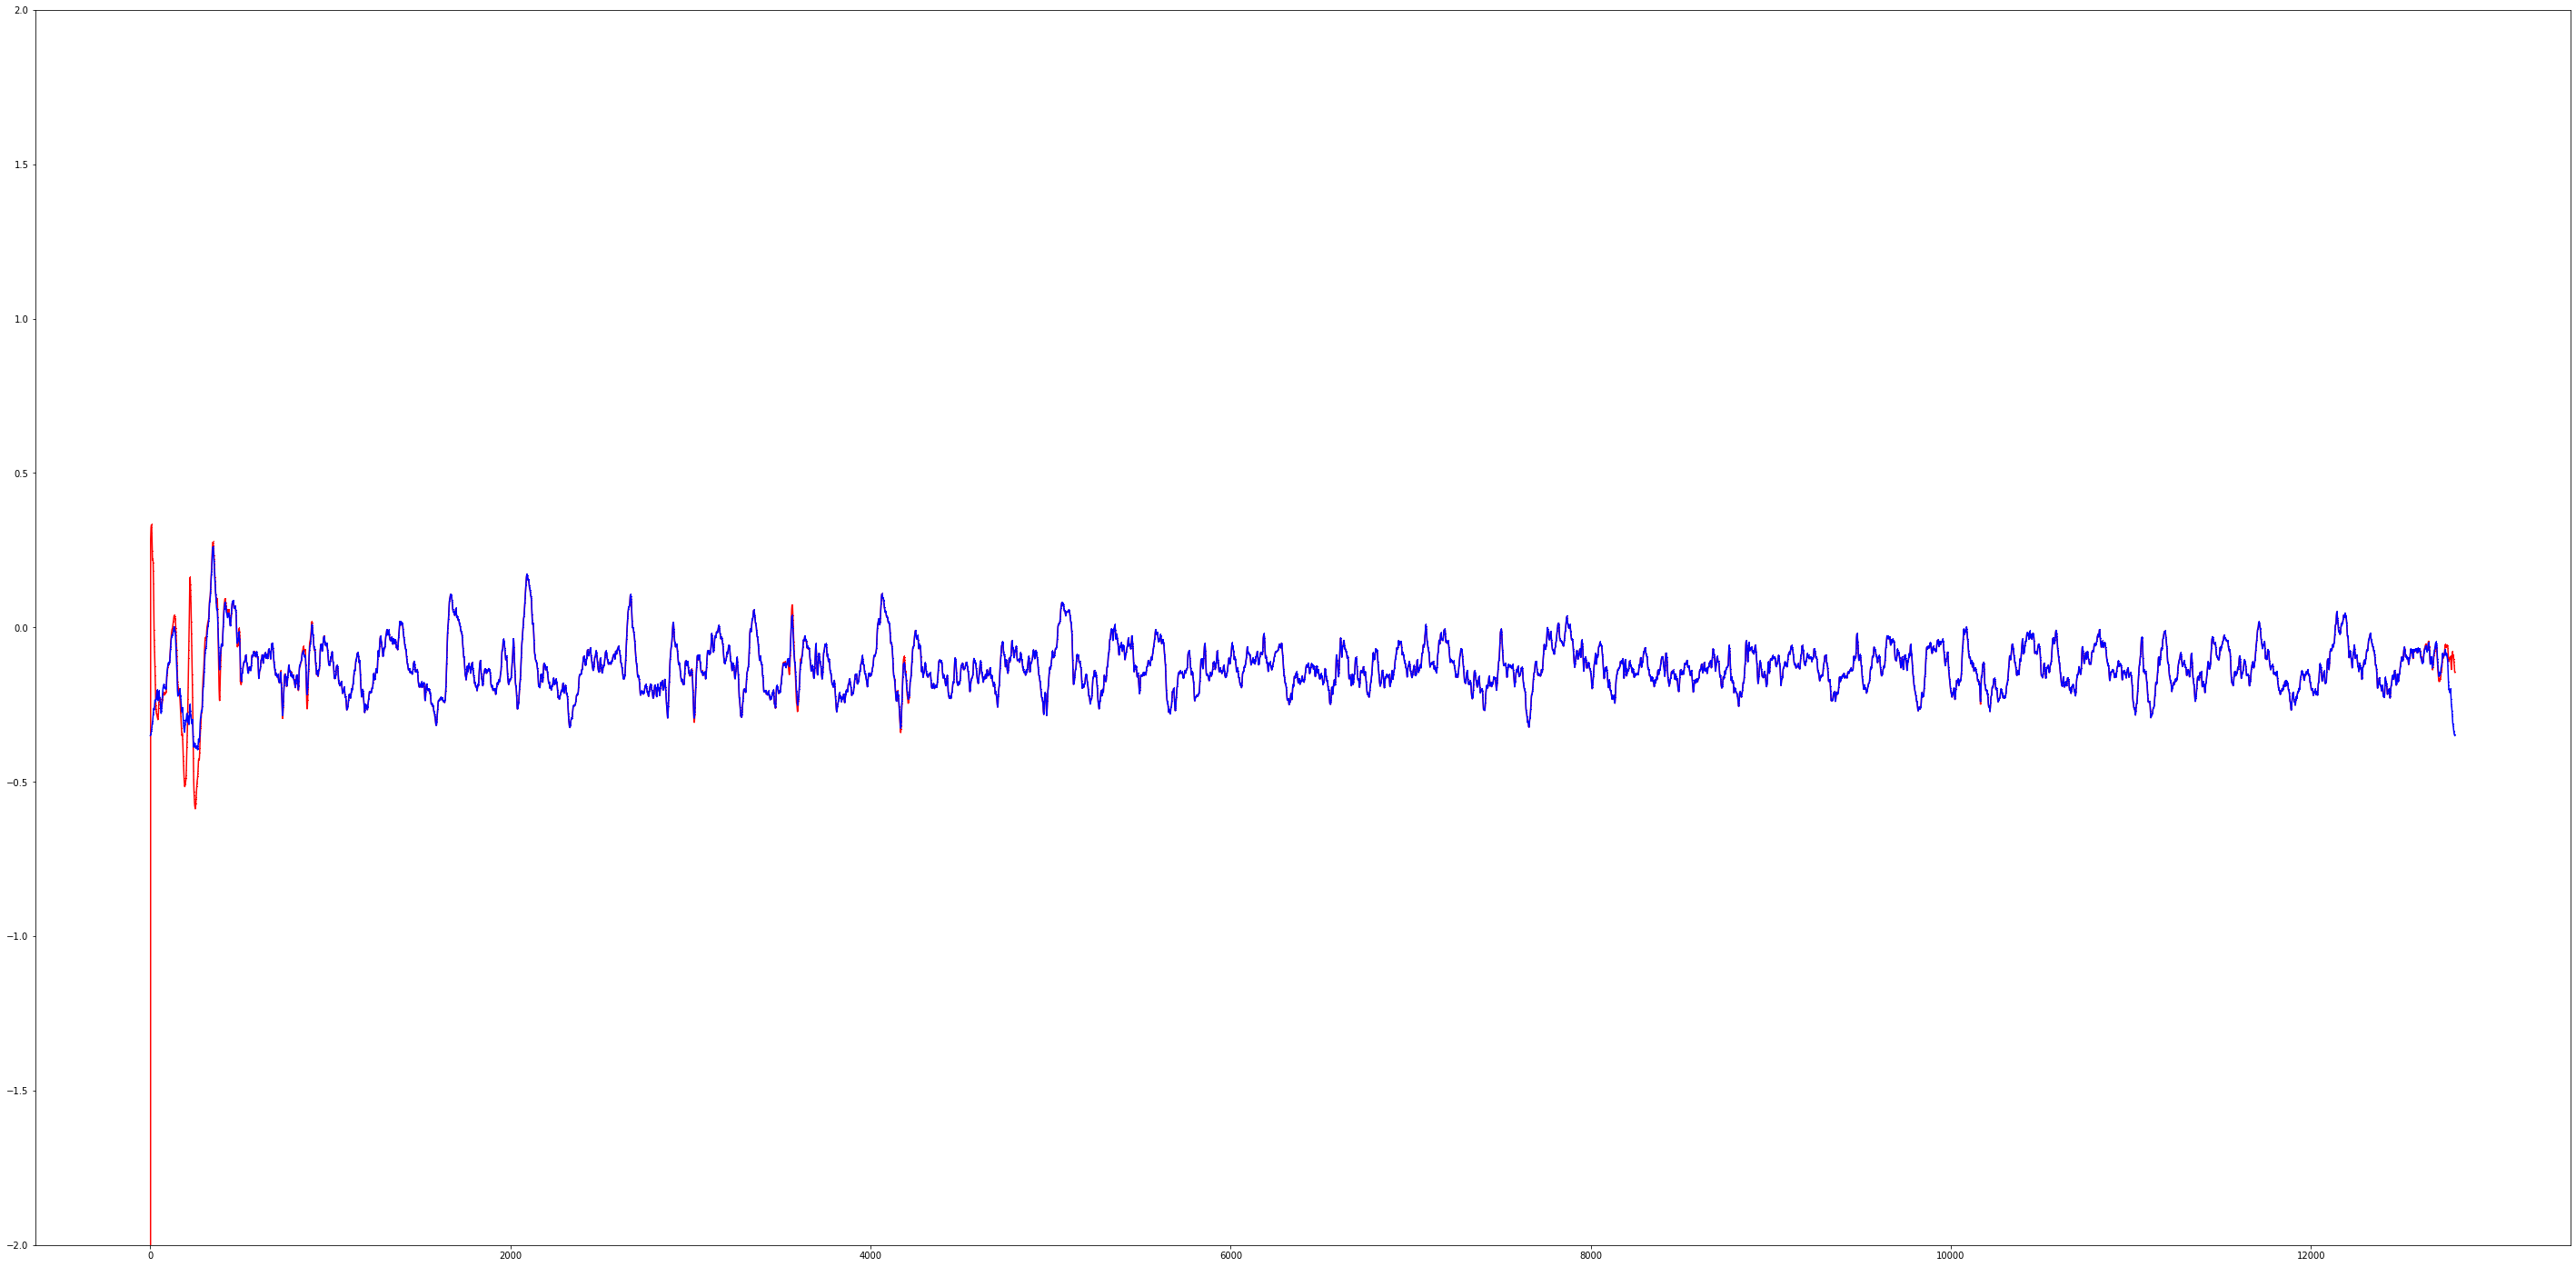

In [11]:
figure2 = pyplot.figure(0, (50, 25))
pyplot.ylim(-2, 2)
component_without_artifact = wt.wavelet_thresholding(ica_components_data[0])
pyplot.plot(np.linspace(0, len(ica_components_data[0]), len(ica_components_data[0])), ica_components_data[0], ',-', color ='r')
pyplot.plot(np.linspace(0, len(component_without_artifact), len(component_without_artifact)), component_without_artifact, ',-', color ='b')

In [12]:
from wica import wi
importlib.reload(wi)
processed_data = wi.wi_for_data(used_data, info['ch_names'], freq=500)

Using matplotlib as 2D backend.


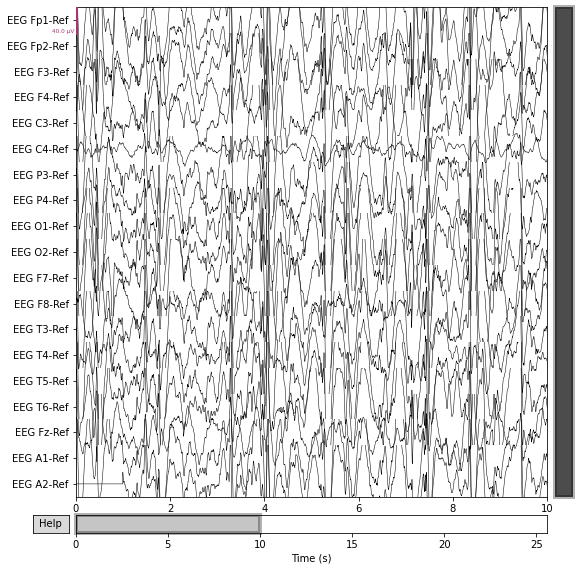

Creating RawArray with float64 data, n_channels=19, n_times=12800
    Range : 0 ... 12799 =      0.000 ...    25.598 secs
Ready.


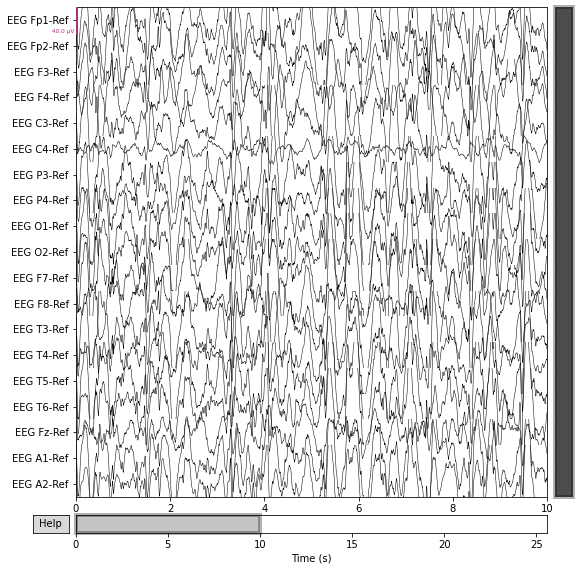

In [13]:
raw.plot()
new_raw = mne.io.RawArray(processed_data, mne.create_info(info["ch_names"], ch_types=["eeg"] * len(info["ch_names"]), sfreq=500))
new_raw.plot();

In [14]:
from preprocessing import emd_ica
importlib.reload(emd_ica)
raw_without_artifacts = emd_ica.emd_ica(processed_data, ch_names=info['ch_names'], freq=info['sfreq'])

'artifact_removal, channel_number: 19 data_length: 12800'
imf_ch_names
['Fp1-Ref imf1',
 'Fp1-Ref imf2',
 'Fp1-Ref imf3',
 'Fp1-Ref imf4',
 'Fp1-Ref imf5',
 'Fp1-Ref imf6',
 'Fp1-Ref imf7',
 'Fp1-Ref imf8',
 'Fp1-Ref imf9',
 'Fp1-Ref imf10',
 'Fp1-Ref imf11',
 'Fp2-Ref imf1',
 'Fp2-Ref imf2',
 'Fp2-Ref imf3',
 'Fp2-Ref imf4',
 'Fp2-Ref imf5',
 'Fp2-Ref imf6',
 'Fp2-Ref imf7',
 'Fp2-Ref imf8',
 'Fp2-Ref imf9',
 'Fp2-Ref imf10',
 'Fp2-Ref imf11',
 'Fp2-Ref imf12',
 'F3-Ref imf1',
 'F3-Ref imf2',
 'F3-Ref imf3',
 'F3-Ref imf4',
 'F3-Ref imf5',
 'F3-Ref imf6',
 'F3-Ref imf7',
 'F3-Ref imf8',
 'F3-Ref imf9',
 'F3-Ref imf10',
 'F3-Ref imf11',
 'F3-Ref imf12',
 'F4-Ref imf1',
 'F4-Ref imf2',
 'F4-Ref imf3',
 'F4-Ref imf4',
 'F4-Ref imf5',
 'F4-Ref imf6',
 'F4-Ref imf7',
 'F4-Ref imf8',
 'F4-Ref imf9',
 'F4-Ref imf10',
 'F4-Ref imf11',
 'F4-Ref imf12',
 'C3-Ref imf1',
 'C3-Ref imf2',
 'C3-Ref imf3',
 'C3-Ref imf4',
 'C3-Ref imf5',
 'C3-Ref imf6',
 'C3-Ref imf7',
 'C3-Ref imf8',
 'C3-Ref imf9',

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 119 out of 119 | elapsed:    0.0s finished


Selecting by number: 40 components
Fitting ICA took 3.1s.
Applying ICA to Raw instance
    Transforming to ICA space (40 components)
    Zeroing out 28 ICA components
    Projecting back using 119 PCA components
Creating RawArray with float64 data, n_channels=19, n_times=12800
    Range : 0 ... 12799 =      0.000 ...    25.598 secs
Ready.
(19, 12800)
[Errno 2] No such file or directory: 'D:\\workspace2\\eeg-epilepsy\\wica\\info.json'


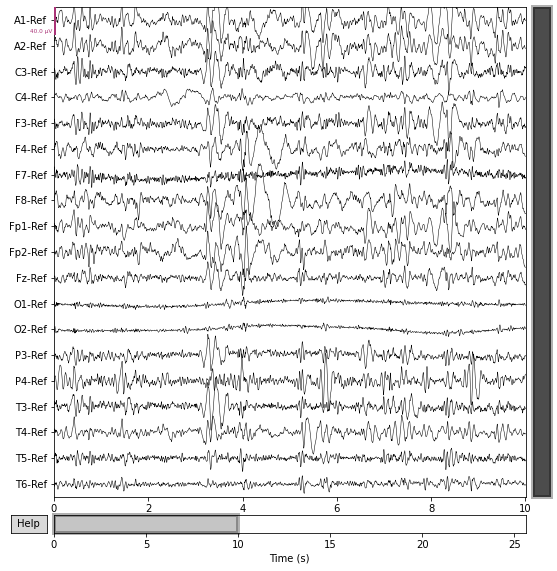

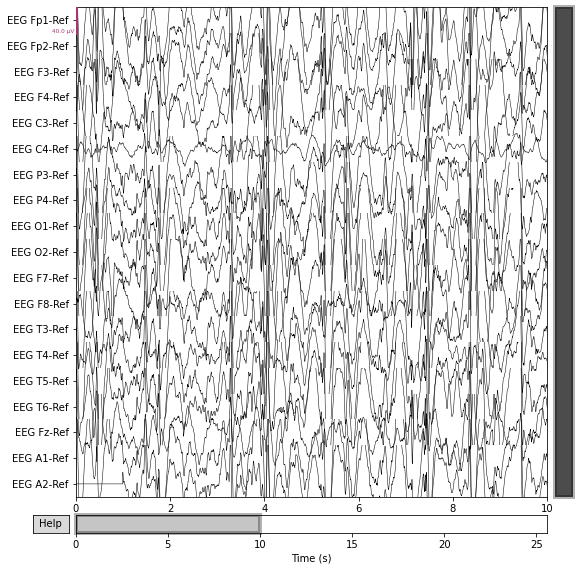

In [15]:
raw_without_artifacts.plot()
raw.plot();